### Quantum Teleportation

## Building your own quantum teleportation circuit

Quantum teleportation is a technique for transferring quantum information from a sender at one location to a receiver some distance away.
Quantum teleportation is a technique for transferring quantum information from a sender at one location to a receiver some distance away.

Lets say Alice wants to send a message to Bob. Specifically, suppose she wants to send the qubit state |𝜓⟩=𝛼|0⟩+𝛽|1⟩.

According to the "no-cloning" theorm, you cannot make an exact copy of an unknown quantum state. Therefore Alice cannot generate a copy of |𝜓⟩ and send the copy to Bob as we cannot copy a superposition of state. However, if we were transmitting classical information, we can do this task of copying and sending the bits.

If two classical bits and an entangled qubit pair is used, Alice can transfer her state |𝜓⟩ to Bob. This is called quantum teleportation as at the end Bob will have |𝜓⟩ and Alice will not anymore. Quantum teleportation is important because this is the only way Alice can send information to Bob and not violate the law of conservation of information.

### The Quantum Teleportation Protocol

1. To transfer a qubit, Alice and Bob must use a third party (Eve) to send them an entangled qubit pair.


2. Alice performs some operations on her qubit, sends the results to Bob over a classical communication channel, and Bob then performs some operations on his end to receive Alice’s qubit.

First, we will import the required libraries from qiskit

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit import *
import matplotlib.pyplot as plt
%matplotlib inline
from qiskit.visualization import plot_histogram

Since the quantum teleportation protocol uses 3 qubits, and 2 classical bits(stored in different registers), we will initialize the Quantum Registers and make our teleportation circuit.

In [2]:
qr = QuantumRegister(3)    
cr1 = ClassicalRegister(1)
cr2 = ClassicalRegister(1)
teleportation_circuit = QuantumCircuit(qr, cr1, cr2)

### Step 1: Eve creates an entangled pair

A third party, Eve, needs to create an entangled pair of qubits. She will give one to Bob and one to Alice. The pair Eve creates is a special pair called a Bell pair. In order to create a bell pair between two qubits she must first transfer one of them to the X-basis (|+⟩ and |−⟩) using a Hadamard gate( the default basis used in Qiskit is the computational basis), and apply a CNOT gate onto the other qubit controlled by the one in the X-basis. The CNOT gate is a binary gate that is applied on two qubits that is the way used to create an entangled pair. We will write code to create a circuit and apply the CNOT gate

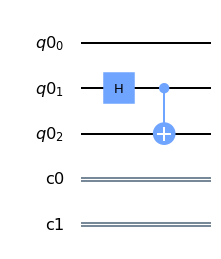

In [3]:
def entanglement_bell_pair(qc, a, b):
    
    qc.h(a) # Put qubit a into state |+> or |-> using hadamard gate
    qc.cx(a,b) # CNOT with a as control and b as target

#  Eve entangles qubits q1 and q2

entanglement_bell_pair(teleportation_circuit, 1, 2)
teleportation_circuit.draw(output='mpl')

### Step 2: Alice applies quantum gates to her bits

Alice needs to apply a CNOT gate to 𝑞1 , controlled by |𝜓⟩ (the qubit she sends to Bob which is q0). Then Alice applies a Hadamard gate to |𝜓⟩ .

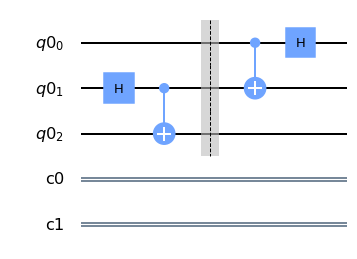

In [4]:
def alice_state_qubits(qc, psi, a):
    qc.cx(psi, a) #psi is the state of q0
    qc.h(psi)
    
# call the function to our circuit
teleportation_circuit.barrier()
alice_state_qubits(teleportation_circuit, 0, 1)
teleportation_circuit.draw(output='mpl')

### Step 3- Alice measures state of qubits, stores results in classical bits and sends it to Bob

Next, Alice applies a measurement to both qubits that she owns, 𝑞1 and |𝜓⟩ , and stores this result in two classical bits. She then sends these two bits to Bob as we know that this will not violate the no-cloning theorm.

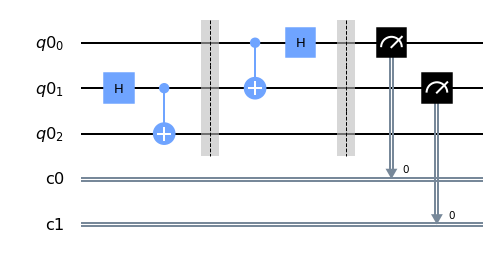

In [5]:
def measure_classical_send(qc, a, b):
    
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

measure_classical_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw(output='mpl')

### Step 4: Bob decodes 

Bob, who already has the qubit 𝑞2, applies quantum gates based on bits he receives

00 →→ Identity

01 →→ Apply 𝑋 gate

10 →→ Apply Z gate

11 →→ Apply 𝑍𝑋 gate

In [6]:
#based on cr1 and cr2 which store the classical bits
def bob_apply_gates(qc, qubit, cr1, cr2):

    qc.z(qubit).c_if(cr1, 1)  #if cr1 is 1 apply Z gate
    qc.x(qubit).c_if(cr2, 1) #if cr2 is 1 apply x gate, look at table above

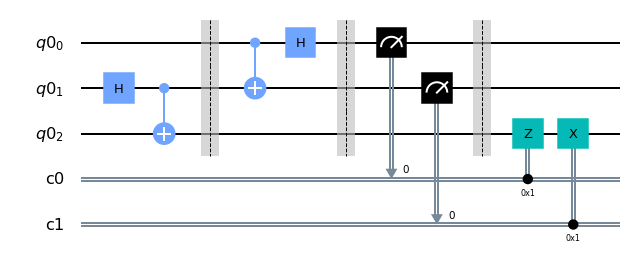

In [7]:
# Let's apply this to our circuit:
teleportation_circuit.barrier() # Use barrier to separate steps
bob_apply_gates(teleportation_circuit, 2, cr1, cr2)
teleportation_circuit.draw(output='mpl')

### Step 5: Using a quantum computer simulator to test the quantum teleportation protocol

We will initialise Alice's qubit in a random state |𝜓⟩ . This state will be created using an Initialize gate on |𝑞0⟩ . First we will create a random state function

In [8]:
def random_state(nqubits):
    """Creates a random nqubit state vector"""
    from numpy import append, array, sqrt
    from numpy.random import random
    real_parts = array([])
    im_parts = array([])
    for amplitude in range(2** nqubits):
        real_parts = append(real_parts, (random()*2)-1)
        im_parts = append(im_parts, (random()*2)-1)
    # Combine into list of complex numbers:
    amps = real_parts + 1j*im_parts
    # Normalise
    magnitude_squared = 0
    for a in amps:
        magnitude_squared += abs(a)** 2
    amps /= sqrt(magnitude_squared)
    return amps
#specify a random state

psi = random_state(1)

Define initialisation gate to create |𝜓⟩ from the state |0⟩ :

In [9]:
from qiskit.extensions import Initialize
init_gate = Initialize(psi)

### Step 6: Test the quantum teleportation protocol

Now we will call all the functions we have created so far and test our quantum teleportation protocol

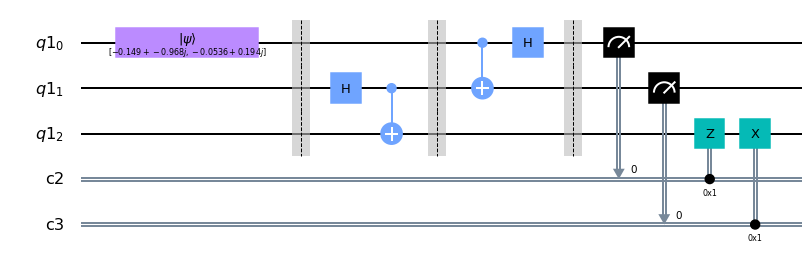

In [10]:
qr = QuantumRegister(3)   
cr1 = ClassicalRegister(1) 
cr2 = ClassicalRegister(1)
qc = QuantumCircuit(qr, cr1, cr2)

#let's initialise Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# teleportation protocol
entanglement_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_state_qubits(qc, 0, 1)

# alice sends to Bob
measure_classical_send(qc, 0, 1)

# Bob decodes qubits
bob_apply_gates(qc, 2, cr1, cr2)

qc.draw(output='mpl')

### Step 7: Execute on backend

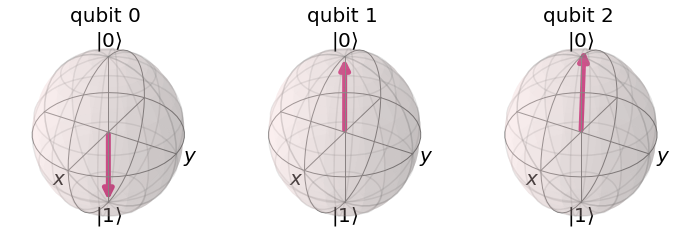

In [11]:
backend = BasicAer.get_backend('statevector_simulator')
out_vector = execute(qc, backend).result().get_statevector()
plot_bloch_multivector(out_vector)

Quantum teleportation is designed to send qubits between two parties.

On a real quantum computer, we would not be able to use the statevector, so to check teleportation circuit is working, we need to do things slightly differently. You will remember that we used Initialize to turn our |0⟩ qubit into the state |𝜓⟩

|0⟩−→−−−−Initialise|𝜓⟩

Since all quantum gates are reversible, we can find the the inverse of Initialise using:

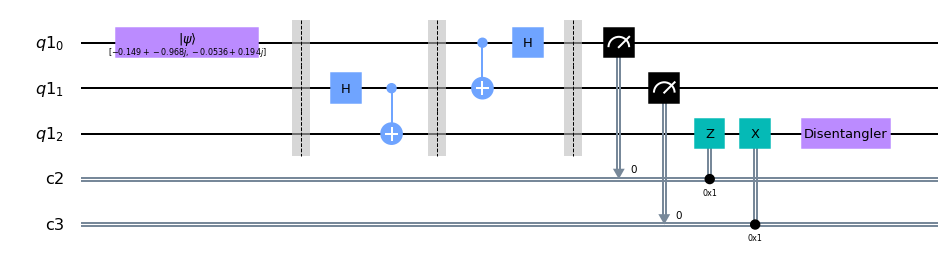

In [12]:
inverse_init_gate = init_gate.gates_to_uncompute()
qc.append(inverse_init_gate, [2])
qc.draw(output='mpl')

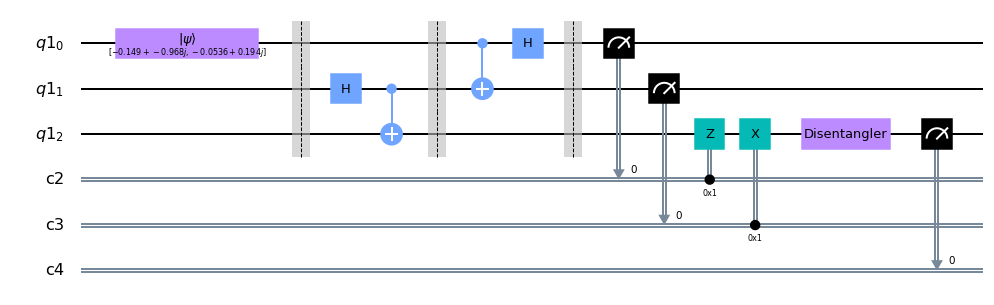

In [13]:
#add a new classical register to see the result
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw(output='mpl')

Plot the histogram of the results

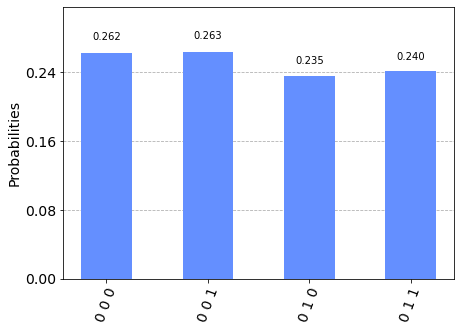

In [14]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts()
plot_histogram(counts)

We can see we have a 100% chance of measuring 𝑞2 (the leftmost bit in the string) in the state |0⟩ . This is the expected result, and indicates the teleportation protocol has worked properly.